In [1]:
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import numpy as np
import scipy.io as sio
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import random
np.random.seed(0)
random.seed(0)


import warnings
warnings.filterwarnings("ignore")



In [2]:

# cross-validation  with baseline include 0 class . accuracy =1- err  err=abs(y_pred-y_test)/3  

def valid(x,y,opt):
    if x.shape[1] == 15 :
        featureName=['VarBR','Varpp','VarIn','VarEx', 'meanBR',\
             'meanIn', 'meanEx' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX']
    if x.shape[1] == 18 :
        featureName=['CovBR','CovPP','CovIN','CovEX', 'meanBR',\
             'meanIN', 'meanEX' ,'r1 BR','r1 PP','r1 IN','r1 EX','r2 BR','r2 PP','r2 IN','r2 EX',\
            'meanHR','sdnn','rmsrr']
    thres=0.85
    acc=[]
    impt=[]
    scale=y[0,:]
    if y.shape[0] ==2:
      group=y[1,:]
      
    acc_max_temp=0  
    tree_max=[]
    a=opt[2]
    b=opt[3]
    ran=0
    if opt[0]=='kfold':
        rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=ran)

        
        for train_ind, test_ind in rkf.split(x,scale):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
            
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a,random_state=ran).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None,random_state=ran).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)


    if opt[0]=='group':
        rkf = LeaveOneGroupOut()

        for train_ind, test_ind in rkf.split(x,scale,group):
            #print("%s %s" % (train_ind, test_ind))
            #print(test_ind)
            X_train=x[train_ind] 
            X_test=x[test_ind]
            y_train=scale[train_ind] 
            y_test=scale[test_ind]
            
            acc_temp=np.zeros((8,))
            impt_temp=np.zeros((8,x.shape[1]))
            
             
            for i in range(8):
                if  opt[1]=='tree':
                    tree1 = DecisionTreeRegressor(max_depth=a).fit(X_train,y_train)
                if  opt[1]=='forest':
                    tree1 = RandomForestRegressor(max_depth=b,n_estimators=40,max_features=None).fit(X_train,y_train)

                y_p=tree1.predict(X_test)
                acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
                acc_temp[i]=np.mean(acc_t)
                impt_temp[i,:]=tree1.feature_importances_
                if acc_temp[i] >= thres:
                    acc_max_temp=acc_temp[i]
                    tree_max.append(tree1)

            max=np.max(acc_temp)
            ind=np.where(acc_temp == np.amax(acc_temp))
            ind=np.min(ind)
            impt_max=impt_temp[ind,:]
            acc.append(max) 
            impt.append(impt_max)

    impt=np.array(impt) 
    importance1=np.mean(impt,axis=0)
    seq=np.argsort(importance1)
    featureName=np.array(featureName)
    featureName1=featureName[seq]
    importance1=importance1[seq]
    importance1=np.flip(importance1)
    featureName1=np.flip(featureName1)
        
    acc=np.array(acc)
    acc_mean=np.mean(acc)
    print('{n:.3f}'.format(n=acc_mean))
    
    return acc_mean,featureName1,importance1,tree_max,acc_max_temp


In [5]:
def test(X_test,y_test,tree):
    acc_temp=[]
    acc_max_temp=0
    for i in range(len(tree)):
        
        y_p=tree[i].predict(X_test)
        acc_t = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
        
        acc_temp.append(np.mean(acc_t))
        if np.mean(acc_t) >= acc_max_temp:
            acc_max_temp=np.mean(acc_t)
            tree_max=tree[i]
            tree_max_ind=i       
            y=np.stack((y_test, y_p))
    print('{n:.3f}'.format(n=acc_max_temp))
    return acc_max_temp,y,tree_max_ind    #y = test + predict labels

def test_vote(X_test,y_test,tree):
    
    y_p_temp = np.zeros((X_test.shape[0],len(tree)))
    y_p=np.zeros((X_test.shape[0],))
    for i in range(len(tree)):
        y_p_temp[:,i]=tree[i].predict(X_test)

    
    y_p=np.mean(y_p_temp,axis=1)
      
        
    
    #acc = 1-abs(y_p.astype('int')-y_test.astype('int'))/10
    acc = 1-abs(y_p.astype('float')-y_test.astype('float'))/10
    acc=np.mean(acc)
    y_p=np.round(y_p,decimals=2)
    print('{n:.3f}'.format(n=acc))
    y=np.stack((y_test, y_p))
    return acc,y    #y = test + predict labels

In [9]:
score13_n=np.array([4, 9 ,2, 2 ,4 ,3, 6 ,9, 3, 2, 1, 4, 5 ,8, 3,\
    5,3,6,7,7,4,4,7,8,4,6,8,5,1,7,8,3])  # case 1-15  + 16-32   
          
score15_n=np.array([9, 5 ,3 ,5, 4 ,2 ,4 ,3, 1, 1, 4, 1 ,3, 2,\
    4,3,5,2,4,3,1,3,3,2,1,4,4,2,4,6,2])  # case 2-15  + 16-32   revised !!
score11=np.zeros((32,))                  # case 1-15  + 16-32 

score=np.hstack((score13_n,score15_n,score11))
score2=np.hstack((score,score))


score_test=np.array([3,3,4,5,8,6,4,2,\
    2,4,6,7,7,4,7,5,5,6,4,2,7,3,3,\
    0,0,0,0,\
    0,0,0])  # case 1-15 routine 2_4 (8 cases)  + case 16-32 routine 2_4 (15 cases) + case 1-15 normal (3 cases) + case 16-32 normal (last 4 cases)
score2_test=np.hstack((score_test,score_test))

In [10]:

ind_3=np.linspace(0,31,32).astype('int')  # routine 3 15 +17
ind_5=np.linspace(32,62,31).astype('int') # routine 5 14 +17
ind2_5=np.linspace(127,157,31) 
ind2_5=np.hstack((ind_5,ind2_5)).astype('int')

# 18 features include ECG  include NCS and chest belt 
# generate the best decision tree with highest accuracy & calculate mean accuracy
data = sio.loadmat\
    (r"C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\data\output\data_all.mat")
delta_norm = data['deltaNcsBio18']

delta_norm_ncs = data['deltaNcs15']
delta_norm_bio = data['deltaBio15']

group_norm = data['group_norm'].ravel()
group_norm2 = data['group_norm_NcsBio'].ravel()
y1=np.stack((score2, group_norm2))

delta_norm_3=np.delete(delta_norm,ind2_5,axis=0)
y1_3=np.delete(y1,ind2_5,axis=1)

data = sio.loadmat\
    (r"C:\Users\zz587-admin\Documents\dyspnea\2ndExperiment\data\output\data_test_all.mat")
#data = sio.loadmat(r"C:\Sleep test\dyspnea\data\all\data_test.mat")
delta_Ncs_test = data['deltaNcs_test15']
delta_Bio_test = data['deltaBio_test15']
delta2_test=data['deltaNcsBio_test']

opt1=['kfold','tree',8,8]
opt2=['kfold','forest',8,8]
opt3=['group','tree',8,8]
opt4=['group','forest',8,8]

acc1_t_k,featureName1_t_k,importance1_t_k,tree1_k,accMean1_t_k=valid(delta_norm_3,y1_3,opt1)
acc1_f_k,featureName1_f_k,importance1_f_k,forest1_k,accMean1_f_k=valid(delta_norm_3,y1_3,opt2)
acc1_t_g,featureName1_t_g,importance1_t_g,tree1_g,accMean1_t_g=valid(delta_norm_3,y1_3,opt3)
acc1_f_g,featureName1_f_g,importance1_f_g,forest1_g,accMean1_f_g=valid(delta_norm_3,y1_3,opt4)


test_all=np.vstack((delta2_test,delta_norm[ind2_5.astype('int')]))
test_score_all=np.hstack((score2_test,score2[ind2_5.astype('int')]))

acc1_t_t,label_t_all=test_vote(test_all,test_score_all,tree1_k)
acc1_f_t,label_f_all=test_vote(test_all,test_score_all,forest1_k)


0.937
0.944
0.940
0.939
0.798
0.802


In [11]:
ind_5=np.linspace(32,62,31).astype('int') 
delta_norm_ncs_3=np.delete(delta_norm_ncs,ind_5,axis=0)
delta_norm_bio_3=np.delete(delta_norm_bio,ind_5,axis=0)
y2=np.stack((score, group_norm))
y2_3=np.delete(y2,ind_5,axis=1)

acc2_t_k,featureName2_t_k,importance2_t_k,tree2_t_k,accMean2_t_k=valid(delta_norm_ncs_3,y2_3,opt1)
acc2_f_k,featureName2_f_k,importance2_f_k,tree2_f_k,accMean2_f_k=valid(delta_norm_ncs_3,y2_3,opt2)
acc2_t_g,featureName2_t_g,importance2_t_g,tree2_t_g,accMean2_t_g=valid(delta_norm_ncs_3,y2_3,opt3)
acc2_f_g,featureName2_f_g,importance2_f_g,tree2_f_g,accMean2_f_g=valid(delta_norm_ncs_3,y2_3,opt4)


acc3_t_k,featureName3_t_k,importance3_t_k,tree3_t_k,accMean3_t_k=valid(delta_norm_bio_3,y2_3,opt1)
acc3_f_k,featureName3_f_k,importance3_f_k,tree3_f_k,accMean3_f_k=valid(delta_norm_bio_3,y2_3,opt2)
acc3_t_g,featureName3_t_g,importance3_t_g,tree3_t_g,accMean3_t_g=valid(delta_norm_bio_3,y2_3,opt3)
acc3_f_g,featureName3_f_g,importance3_f_g,tree3_f_g,accMean3_f_g=valid(delta_norm_bio_3,y2_3,opt4)


delta_Ncs_test_new=np.vstack((delta_Ncs_test,delta_norm_ncs[ind_5]))
delta_Bio_test_new=np.vstack((delta_Bio_test,delta_norm_bio[ind_5]))
score_test_new=np.hstack((score_test,score[ind_5]))

acc2_t_t,label_ncs_t=test_vote(delta_Ncs_test_new,score_test_new,tree2_t_k)
acc2_f_t,label_ncs_f=test_vote(delta_Ncs_test_new,score_test_new,tree2_f_k)

acc3_t_t,label_bio_t=test_vote(delta_Bio_test_new,score_test_new,tree3_t_k)
acc3_f_t,label_bio_f=test_vote(delta_Bio_test_new,score_test_new,tree3_f_k)

print(label_ncs_f)

0.868
0.878
0.917
0.905
0.900
0.902
0.941
0.929
0.776
0.828
0.764
0.790
[[3.   3.   4.   5.   8.   6.   4.   2.   2.   4.   6.   7.   7.   4.
  7.   5.   5.   6.   4.   2.   7.   3.   3.   0.   0.   0.   0.   0.
  0.   0.   9.   5.   3.   5.   4.   2.   4.   3.   1.   1.   4.   1.
  3.   2.   4.   3.   5.   2.   4.   3.   1.   3.   3.   2.   1.   4.
  4.   2.   4.   6.   2.  ]
 [4.3  0.93 1.16 2.51 6.76 5.31 5.27 1.1  0.82 6.22 2.2  2.37 1.98 4.79
  7.7  2.34 1.81 1.78 5.79 0.76 6.08 0.88 5.53 0.73 0.62 0.92 0.03 0.07
  0.12 0.2  7.61 1.19 1.1  1.19 0.99 0.68 2.21 1.03 0.71 0.58 1.16 0.79
  0.76 0.19 1.94 3.39 0.84 0.38 1.82 1.82 0.74 4.29 1.29 0.9  0.14 2.1
  5.61 1.4  1.9  4.34 1.34]]


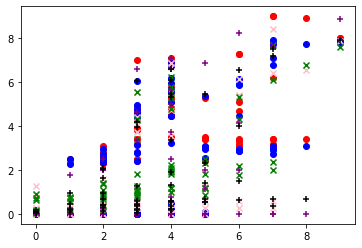

In [13]:
plt.scatter(label_t_all[0,:],label_t_all[1,:],marker='o', c='red',label="NCS+torso-belt+ECG decision tree")

plt.scatter(label_f_all[0,:],label_f_all[1,:],marker='o', c='blue',label="Luck")
plt.scatter(label_ncs_t[0,:],label_ncs_t[1,:],marker='x', c='pink')
plt.scatter(label_ncs_f[0,:],label_ncs_f[1,:],marker='x', c='green')
plt.scatter(label_bio_t[0,:],label_bio_t[1,:],marker='+', c='purple')
plt.scatter(label_bio_f[0,:],label_bio_f[1,:],marker='+', c='black')


from scipy.io import savemat
data = {"label_t_all": label_t_all, "label_f_all": label_t_all,"label_ncs_t": label_ncs_t, "label_ncs_f": label_ncs_f,"label_bio_t": label_bio_t,\
    "label_bio_f": label_bio_f,}
 
savemat(r"C:\Users\zz587-admin\Documents\dyspnea\python\scatter6_ind.mat", data)